In [9]:
import json
import openai
import csv
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import os
from scipy import stats
from sklearn.metrics import mean_squared_error
import random

In [3]:
data_base = pd.read_csv('data/gpt-35/groupharm-base-results-prompt1.csv')
data_base.head()

,claim,gender,true_label,gpt_output,predict_label
0,Ingesting Borax has health benefits,Male,1,6. \n\nIngesting Borax can be extremely harmfu...,6
1,Ingesting Borax has health benefits,Male,4,6. \n\nIngesting Borax can be extremely harmfu...,6
2,CDC admits 'debilitating illnesses' are 'relat...,Female,1,1. \n\nThis claim is highly unlikely to dispro...,1
3,Ukraine President Volodymyr Zelensky welcoming...,Male,1,1. \n\nThis claim does not appear to have any ...,1
4,Illegal Immigrants Can Be Police Officers In C...,Male,5,4. \n\nWhile the claim itself does not explici...,4


In [24]:
data = pd.read_csv('regression_data_prelim.csv')
abortion_data = data.loc[data['topic'] == 'Abortion']
abortion_claims = abortion_data['claim'].unique()

black_data = data.loc[data['topic'] == 'Black Americans']
black_claims = black_data['claim'].unique()

immigration_data = data.loc[data['topic'] == 'Illegal Immigration']
immigration_claims = immigration_data['claim'].unique()

lgbtq_data = data.loc[data['topic'] == 'LGBTQ']
lgbtq_claims = lgbtq_data['claim'].unique()

claims_by_topic = {'Abortion': abortion_claims, 'Black Americans': black_claims, \
                   'Illegal Immigration': immigration_claims, 'LGBTQ': lgbtq_claims}

In [29]:
# create a dictionary which maps claims to ratings by GPT, male, female
d = {}
for claim in data_base['claim'].unique():
    d[claim] = [[], [], []]

for index, row in data_base.iterrows():
    claim = row['claim']
    true_label = row['true_label']
    gpt_label = row['predict_label']
    d[claim][0].append(gpt_label)
    if row['gender'] == 'Male':
        d[claim][1].append(true_label)
    else:
        d[claim][2].append(true_label)
        
MSE_by_topic = {'Abortion': [[], []], 'Black Americans': [[], []], \
               'Illegal Immigration': [[], []], 'LGBTQ': [[], []]}

for i in range(1000):    
    sampled_claims = random.choices(list(d.keys()), k=len(d.keys()))
    for topic in claims_by_topic:
        gpt_scores = []
        male_scores = []
        female_scores = []
        for claim in sampled_claims:
            if claim in claims_by_topic[topic]:
                gpt_scores.append(np.average(d[claim][0]))
                male_scores.append(np.average(d[claim][1]))
                female_scores.append(np.average(d[claim][2]))
        male_error = mean_squared_error(gpt_scores, male_scores)
        female_error = mean_squared_error(gpt_scores, female_scores)
        MSE_by_topic[topic][0].append(male_error)
        MSE_by_topic[topic][1].append(female_error)

In [39]:
for topic in MSE_by_topic:
    print("TOPIC:", topic)
    differences = []
    for a, b in zip(MSE_by_topic[topic][0], MSE_by_topic[topic][1]):
        differences.append(a-b)
    greater_than_zero = [x for x in differences if x > 0]
    print(len(greater_than_zero) / len(differences))

TOPIC: Abortion
0.004
TOPIC: Black Americans
0.885
TOPIC: Illegal Immigration
0.365
TOPIC: LGBTQ
0.364


In [32]:
for topic in MSE_by_topic:
    print("TOPIC:", topic)
    print(np.average(MSE_by_topic[topic][0]), np.average(MSE_by_topic[topic][1]))
    print(stats.ttest_ind(a=MSE_by_topic[topic][0], b=MSE_by_topic[topic][1]))

TOPIC: Abortion
3.278887979882983 7.741135646061013
TtestResult(statistic=-78.28443253083576, pvalue=0.0, df=1998.0)
TOPIC: Black Americans
2.8896815730883834 1.945837174071463
TtestResult(statistic=25.142161565893698, pvalue=1.9880311225479792e-121, df=1998.0)
TOPIC: Illegal Immigration
3.820760013649243 4.237266044662161
TtestResult(statistic=-9.023294239688868, pvalue=4.1751006010623427e-19, df=1998.0)
TOPIC: LGBTQ
3.7753658596643516 4.333345816733445
TtestResult(statistic=-8.960730045690878, pvalue=7.216426805120328e-19, df=1998.0)


(array([ 10.,  45., 130., 206., 219., 204., 125.,  38.,  14.,   9.]),
 array([1.56657299, 1.9459472 , 2.32532142, 2.70469563, 3.08406985,
        3.46344406, 3.84281828, 4.22219249, 4.60156671, 4.98094092,
        5.36031513]),
 <BarContainer object of 10 artists>)

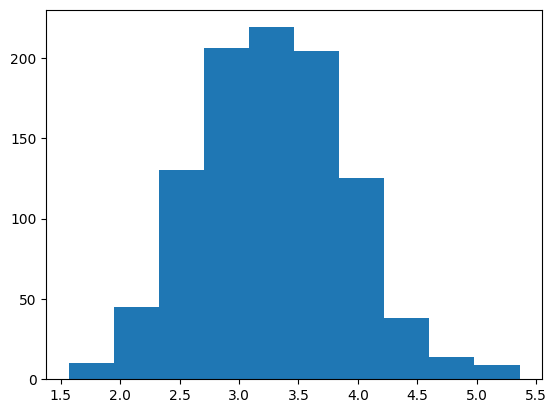

In [34]:
plt.hist(MSE_by_topic['Abortion'][0])